Импорты библиотек

In [1]:
!python --version
!java --version

Python 3.8.0
java 11.0.13 2021-10-19 LTS
Java(TM) SE Runtime Environment 18.9 (build 11.0.13+10-LTS-370)
Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.13+10-LTS-370, mixed mode)


In [2]:
import sys
!python -m pip install --upgrade pip
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install -U gensim --user
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install spacy==2.2.2 --user
!python -m spacy download en_core_web_sm
!{sys.executable} -m pip install bokeh
!{sys.executable} -m pip install pyspark==3.0.3
!{sys.executable} -m pip install findspark
!{sys.executable} -m pip install pyarrow
!{sys.executable} -m pip install fastparquet
import seaborn as sns
import matplotlib.colors as mcolors
import re, numpy as np, pandas as pd
from pprint import pprint

import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
#import pyLDAvis

import nltk
import os
import pyspark
from pyspark.sql import SparkSession, Window
import re as re
from pyspark.ml.feature import CountVectorizer , IDF
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.ml.clustering import LDA, LDAModel
from pyspark.sql import functions as F
from pyspark.sql.functions import size
from pyspark.sql.functions import udf, col
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import udf, struct
import pyspark.sql.types as T 
from pyspark.sql import Row
from pyspark.ml.feature import StopWordsRemover,Tokenizer, RegexTokenizer, CountVectorizer, IDF
from pyspark.sql.functions import udf, col, size, explode, regexp_replace, trim, lower, lit, when, count
from pyspark.sql.types import ArrayType, StringType, DoubleType, IntegerType, LongType
from pyspark.ml.clustering import LDA

from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk import pos_tag

     ---------------------------------------- 12.0/12.0 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maksi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maksi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import findspark
findspark.init()
conf1 = pyspark.SparkConf().setAppName("applicaiton").set("spark.executor.heartbeatInterval", "200000").set("spark.network.timeout", "300000")

Загружаем фрейм и преобразуем массив слов документа

In [4]:
spark = SparkSession.builder.config(conf=conf1).master("local").appName("jupyter_mod4").getOrCreate()
rough_df = spark.read.parquet('G:/Мой диск/datasetGH.parquet')

# *Нормализация* датасета

RegexTokenizer Section

In [5]:
retokenizer = RegexTokenizer().setInputCol("text").setOutputCol("words") \
      .setToLowercase(True) \
      .setPattern("[a-zA-Z]+") \
      .setMinTokenLength(3) \
      .setGaps(False)

StopWords Section

In [6]:
stopWords_Remover = StopWordsRemover() \
      .setInputCol("lemmatized") \
      .setOutputCol("lemmatized_good_words")

Lemmatize Section (UDF func)

In [7]:

def lemmatize(data_arr):
    # expects a string
    cleaned_arr = []
    lmtzr = WordNetLemmatizer()
    tagged_words = pos_tag(data_arr)
    for word in tagged_words:
        if 'n' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='n')
            cleaned_arr.append(lemma)
        if 'adj' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='adj')
            cleaned_arr.append(lemma)
    return cleaned_arr

  
sparkLemmer = udf(lambda x: lemmatize(x), ArrayType(StringType()))

Count vectorization Section

In [8]:
vectorizer = CountVectorizer() \
  .setInputCol("lemmatized_good_words") \
  .setOutputCol("features") \
  .setMinDF(0.02) \
  .setMaxDF(0.6)

Data "*Pipeline*"

In [9]:
spark.sparkContext.setCheckpointDir("~/checkpoints/")
tokenized_df = retokenizer.transform(rough_df)
lemmed_df = tokenized_df.withColumn('lemmatized', sparkLemmer('words')).checkpoint()

In [10]:
stopworder_df = stopWords_Remover.transform(lemmed_df).checkpoint()

In [11]:
count_vectorized_model = vectorizer.fit(stopworder_df)
count_vectorized_df = count_vectorized_model.transform(stopworder_df).select("label", "lemmatized_good_words", "features")

In [12]:
# NLTK Stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['first','second','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maksi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = pd.read_parquet("G:/Мой диск/datasetGH.parquet")['text'].tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['field', 'of', 'the', 'inventionthe', 'invention', 'relates', 'to', 'audio', 'processing', 'systems', 'and', 'particularly', 'customized', 'audio', 'adjustment', 'systems', 'description', 'of', 'the', 'related', 'audio', 'players', 'are', 'nearly', 'ubiquitous', 'the', 'popularization', 'of', 'smartphones', 'has', 'ushered', 'in', 'an', 'environment', 'where', 'anyone', 'and', 'everyone', 'with', 'smartphone', 'has', 'an', 'on', 'board', 'personal', 'audio', 'player', 'personal', 'audio', 'is', 'typically', 'delivered', 'to', 'user', 'by', 'headphones', 'headphones', 'are', 'pair', 'of', 'small', 'speakers', 'that', 'are', 'designed', 'to', 'be', 'held', 'in', 'place', 'close', 'to', 'users', 'ears', 'they', 'may', 'be', 'electroacoustic', 'transducers', 'which', 'convert', 'an', 'electrical', 'signal', 'to', 'corresponding', 'sound', 'in', 'the', 'users', 'ear', 'headphones', 'are', 'designed', 'to', 'allow', 'single', 'user', 'to', 'listen', 'to', 'an', 'audio', 'source', 'privatel

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
t = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = t(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [45]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

id2word.filter_extremes(no_below=1, no_above=0.5)
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]



# GENSIM LDA и графики

In [89]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=2,
                                            random_state=100,
                                            update_every=0,
                                            chunksize=10,
                                            passes=100,
                                            alpha='auto',
                                            iterations=100,
                                            per_word_topics=True)
pprint(lda_model.print_topics())

[(0,
  '0.024*"signal" + 0.014*"power" + 0.011*"portion" + 0.010*"display" + '
  '0.008*"surface" + 0.008*"frequency" + 0.007*"electronic" + 0.007*"unit" + '
  '0.006*"transmission" + 0.006*"layer"'),
 (1,
  '0.015*"image" + 0.015*"display" + 0.010*"unit" + 0.009*"terminal" + '
  '0.009*"network" + 0.008*"control" + 0.008*"resource" + 0.008*"transmission" '
  '+ 0.007*"message" + 0.007*"screen"')]


Работа с данными топиков кластеризации

In [90]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return (sent_topics_df)
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print(df_dominant_topic.head(10))
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)
# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

C:\Users\maksi\AppData\Local\Temp\ipykernel_10924\1306961922.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(
C:\Users\maksi\AppData\Local\Temp\ipykernel_10924\1306961922.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(


   Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               0              0.9711   
1            1               1              0.9998   
2            2               1              0.9998   
3            3               0              0.9998   
4            4               0              0.5495   
5            5               0              0.7347   
6            6               0              0.9266   
7            7               0              0.8034   
8            8               1              0.8168   
9            9               1              0.9999   

                                                                                     Keywords  \
0  signal, power, portion, display, surface, frequency, electronic, unit, transmission, layer   
1   image, display, unit, terminal, network, control, resource, transmission, message, screen   
2   image, display, unit, terminal, network, control, resource, transmission, message, screen   
3  signal, power,

**Топики** - Наиболее репрезентативное предложение для каждой темы

In [91]:
print("show topics")
print(sent_topics_sorteddf_mallet.head(10))

show topics
   Topic_Num  Topic_Perc_Contrib  \
0          0                 1.0   
1          1                 1.0   

                                                                                     Keywords  \
0  signal, power, portion, display, surface, frequency, electronic, unit, transmission, layer   
1   image, display, unit, terminal, network, control, resource, transmission, message, screen   

                                                                                   Representative Text  
0  [application, continuation, patent, application, ser, application, priority, provisional, patent...  
1  [application, continuation, reference, entirety, ser, claim, provisional, application, reference...  


График 1 - Частотное распределение количества слов в документах

show graph1


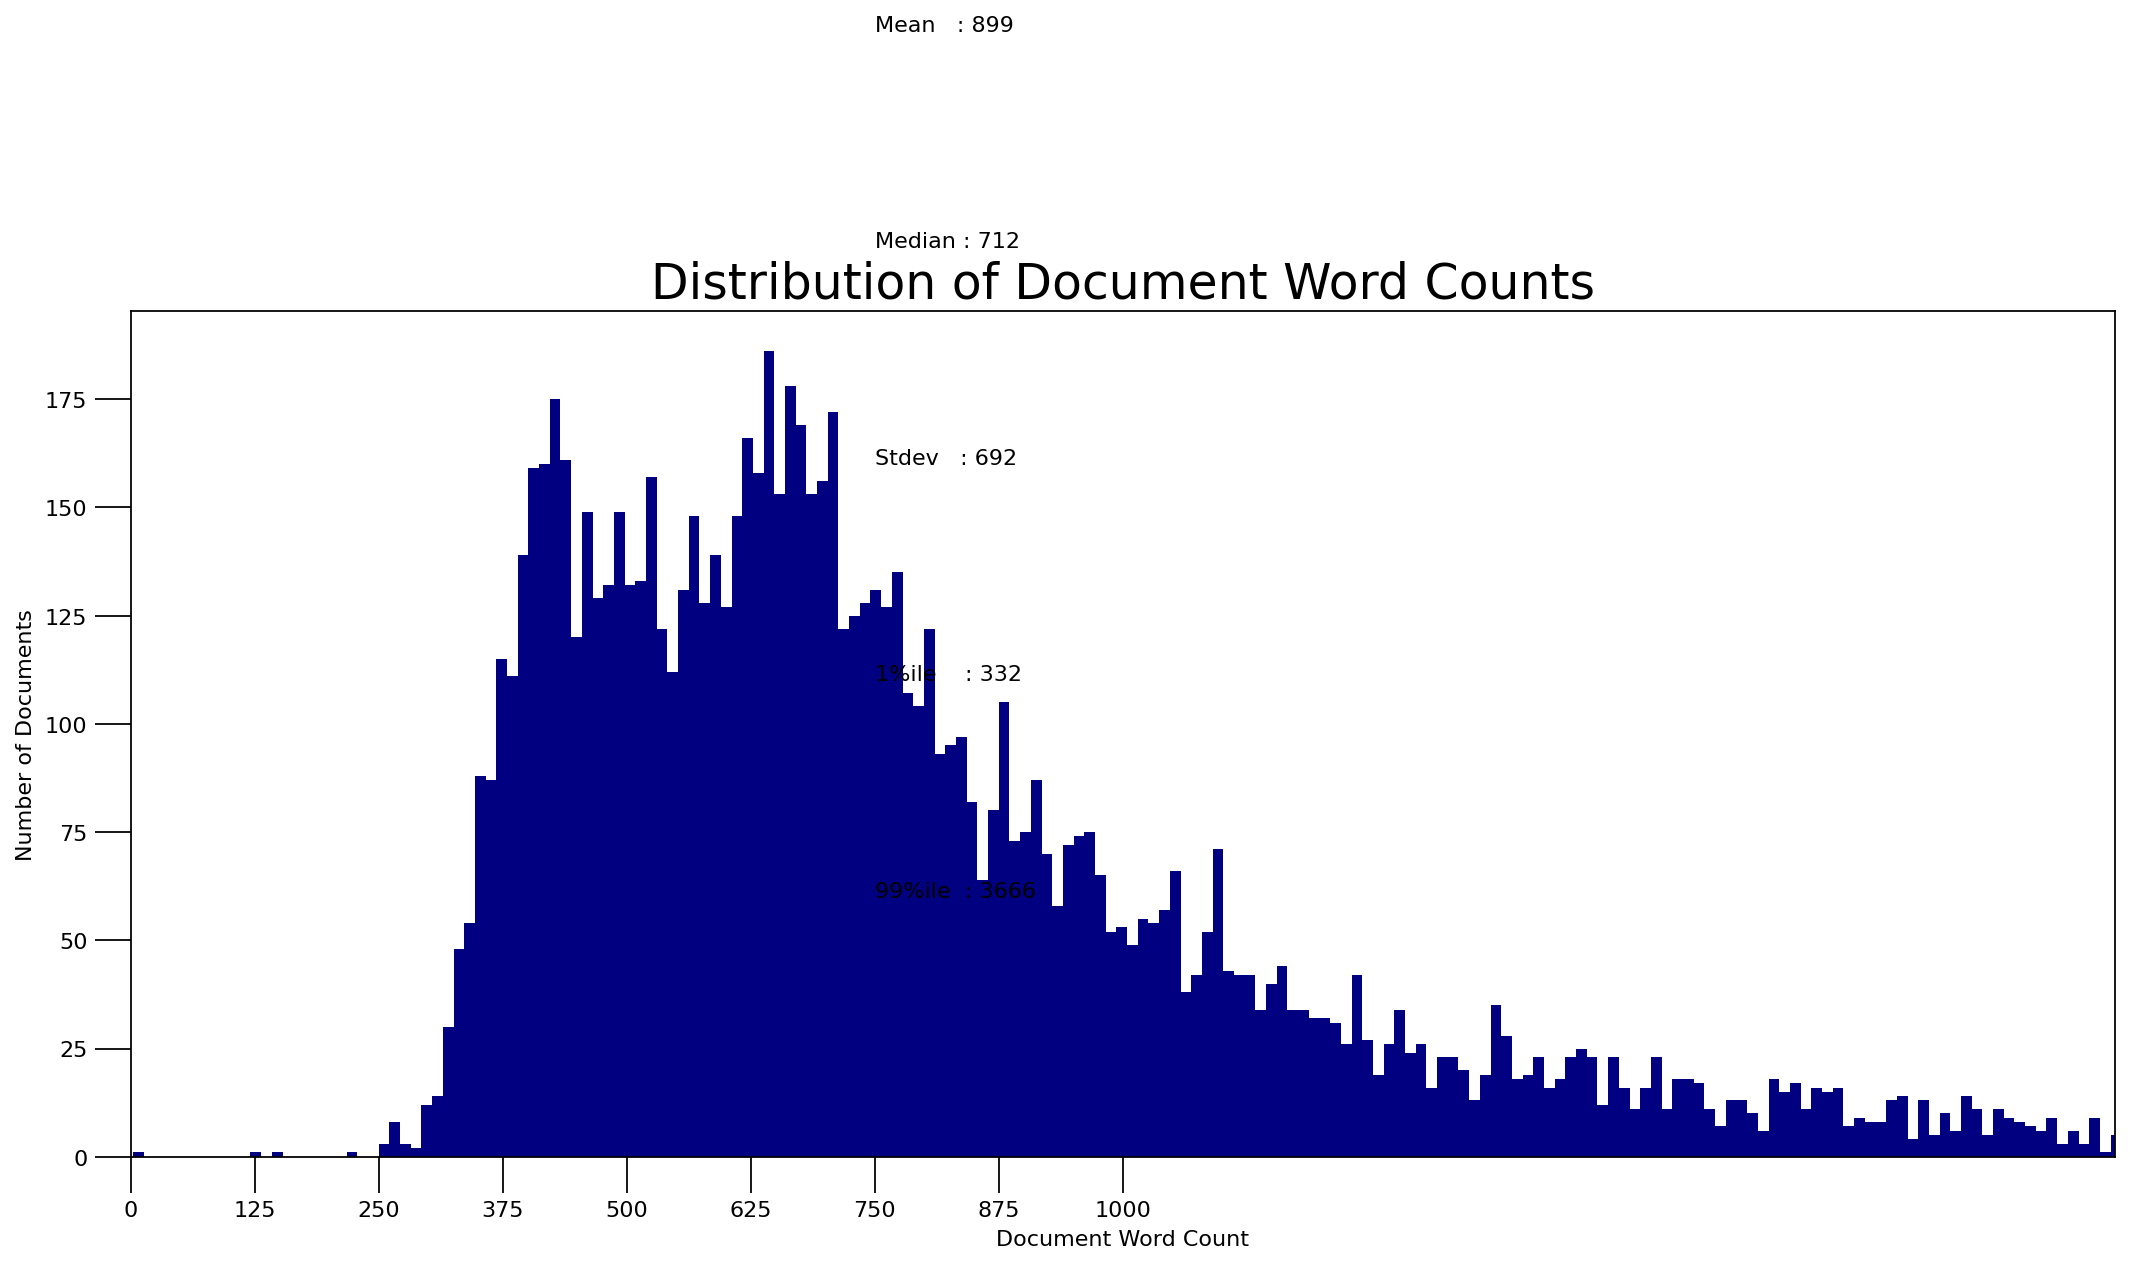

In [92]:
doc_lens = [len(d) for d in df_dominant_topic.Text]
# Plot
plt.figure(figsize=(16, 7), dpi=160)
plt.hist(doc_lens, bins=1000, color='navy')
plt.text(750, 260, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750, 210, "Median : " + str(round(np.median(doc_lens))))
plt.text(750, 160, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750, 110, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750, 60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))
plt.gca().set(xlim=(0, 2000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0, 1000, 9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
print("show graph1")
plt.show()

График 2 - Распределение количества слов в документе по доминирующей теме

show graph2


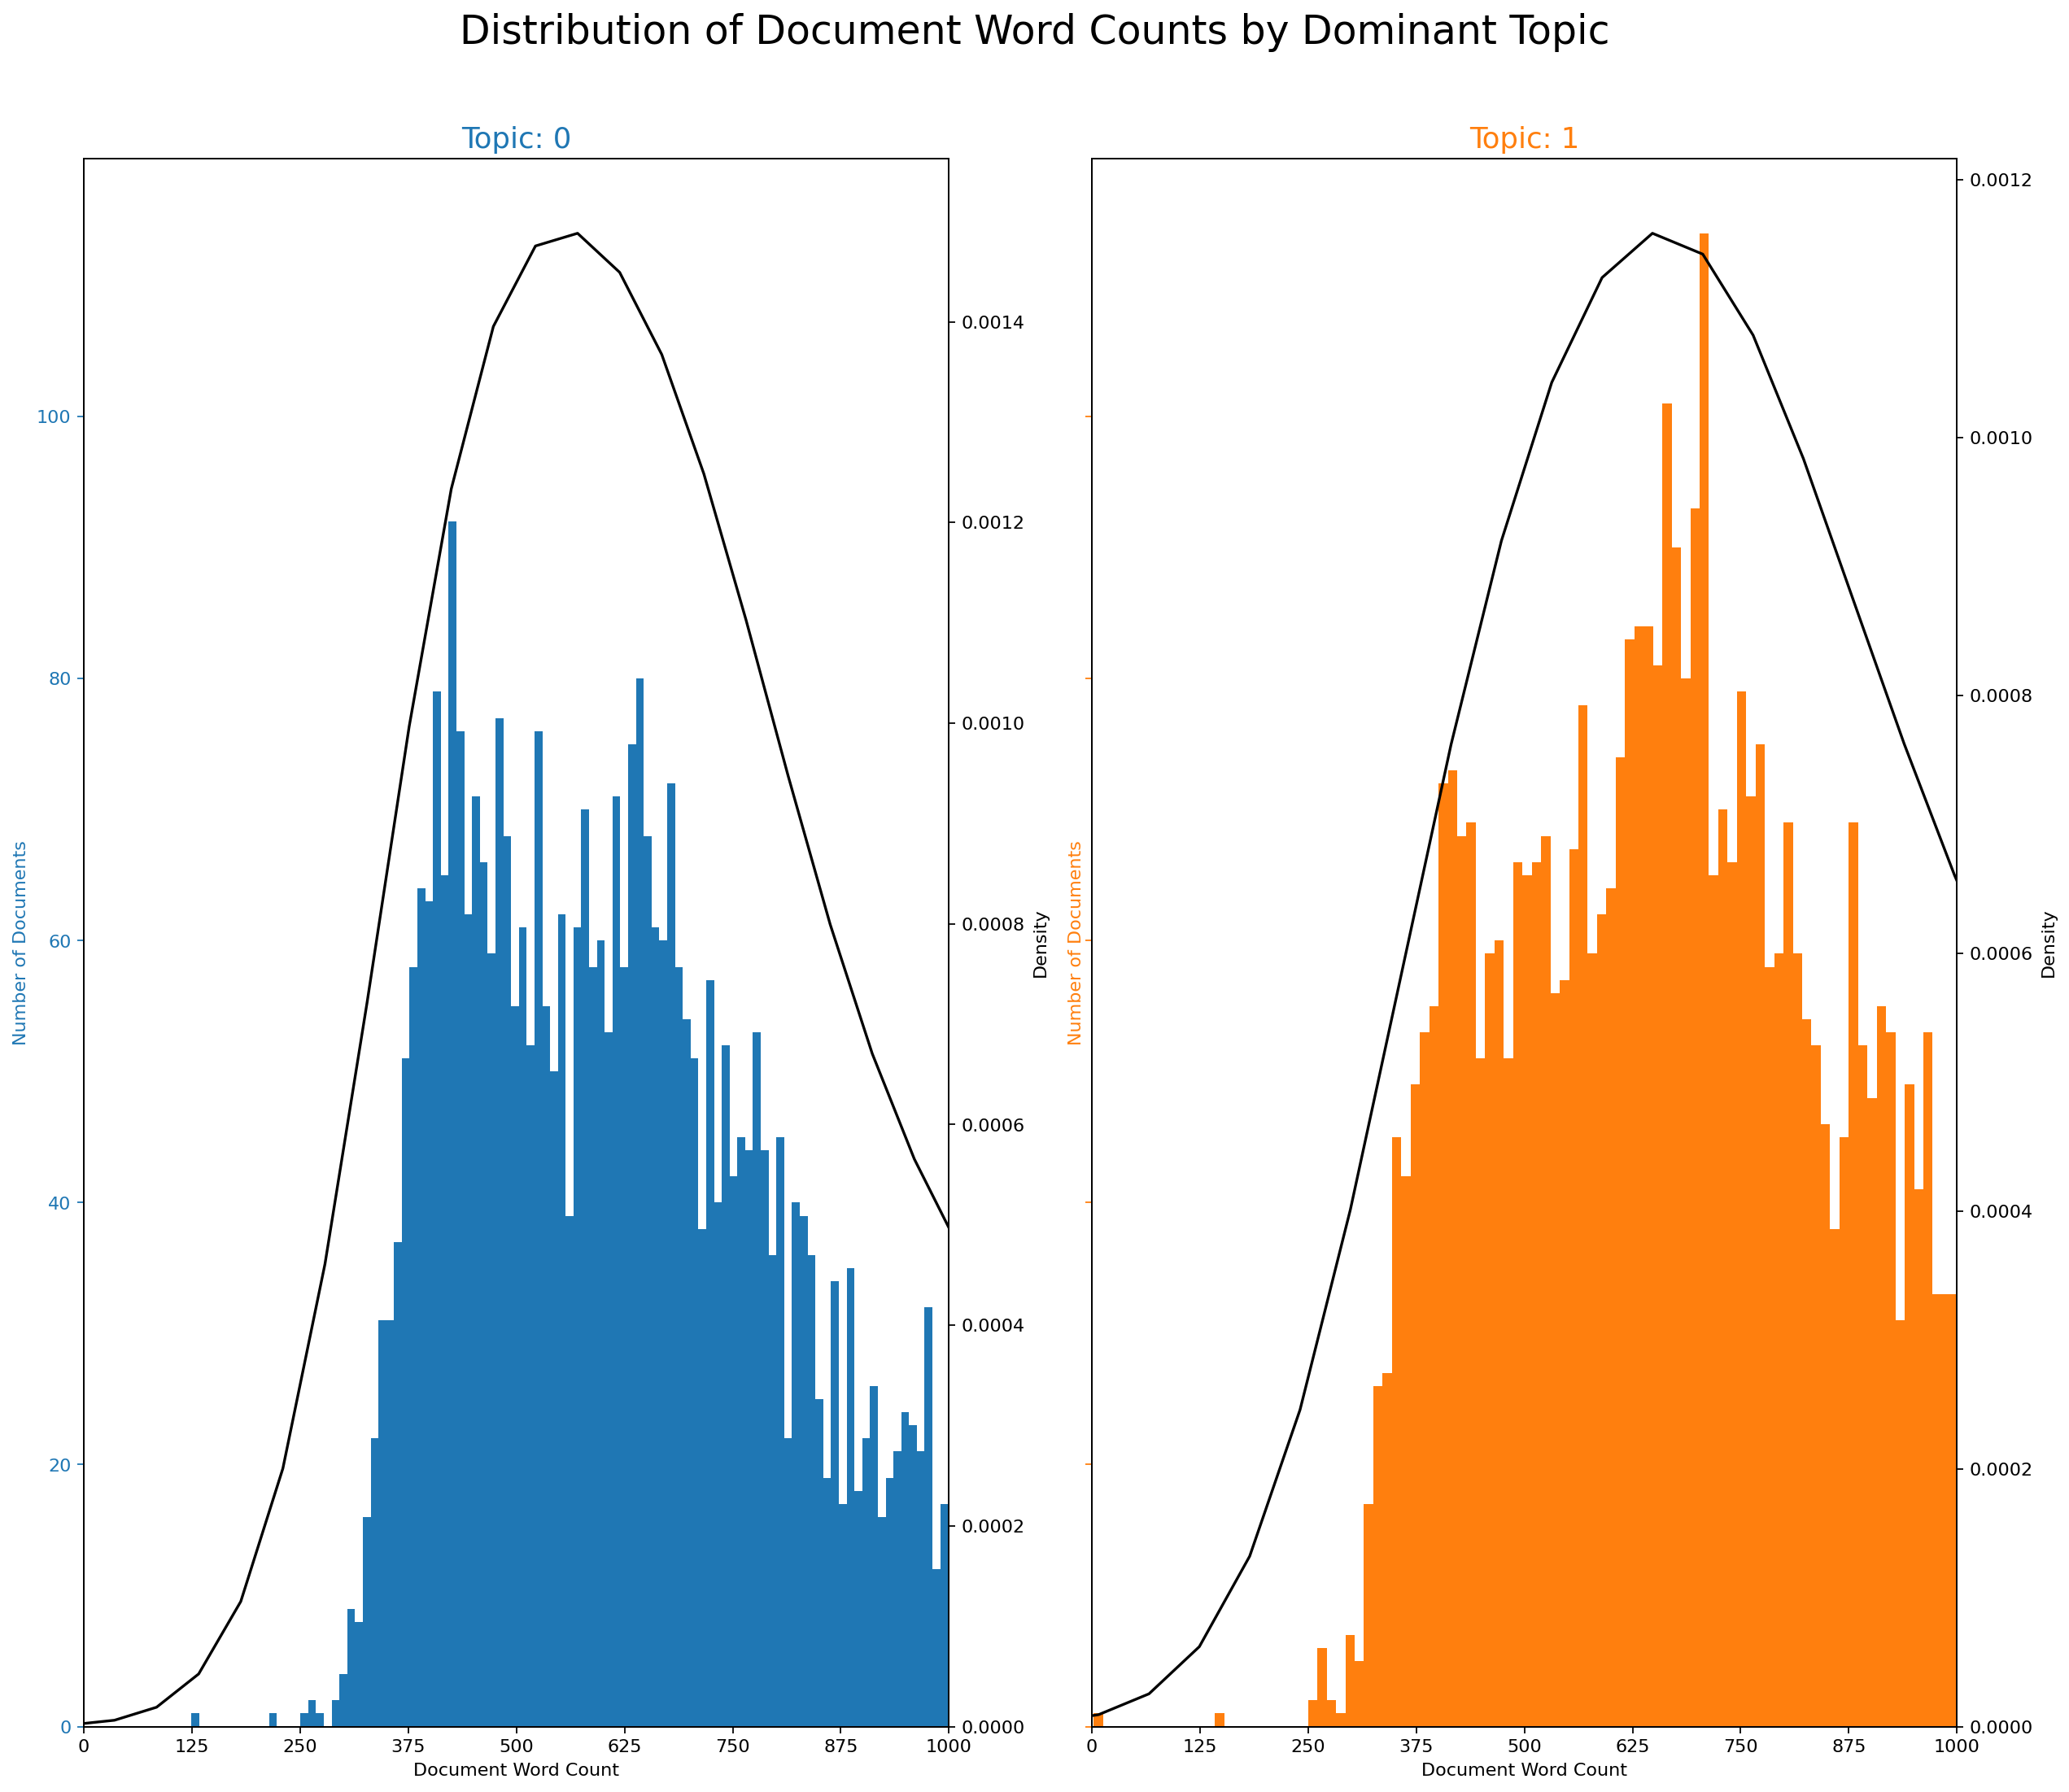

In [93]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(1, 2, figsize=(16, 14), dpi=160, sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins=1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: ' + str(i), fontdict=dict(size=16, color=cols[i]))
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0, 1000, 9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
print("show graph2")
plt.show()

График 3 - Количество слов и важность ключевых слов темы

C:\Users\maksi\AppData\Local\Temp\ipykernel_10924\2493551739.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
C:\Users\maksi\AppData\Local\Temp\ipykernel_10924\2493551739.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


show graph3


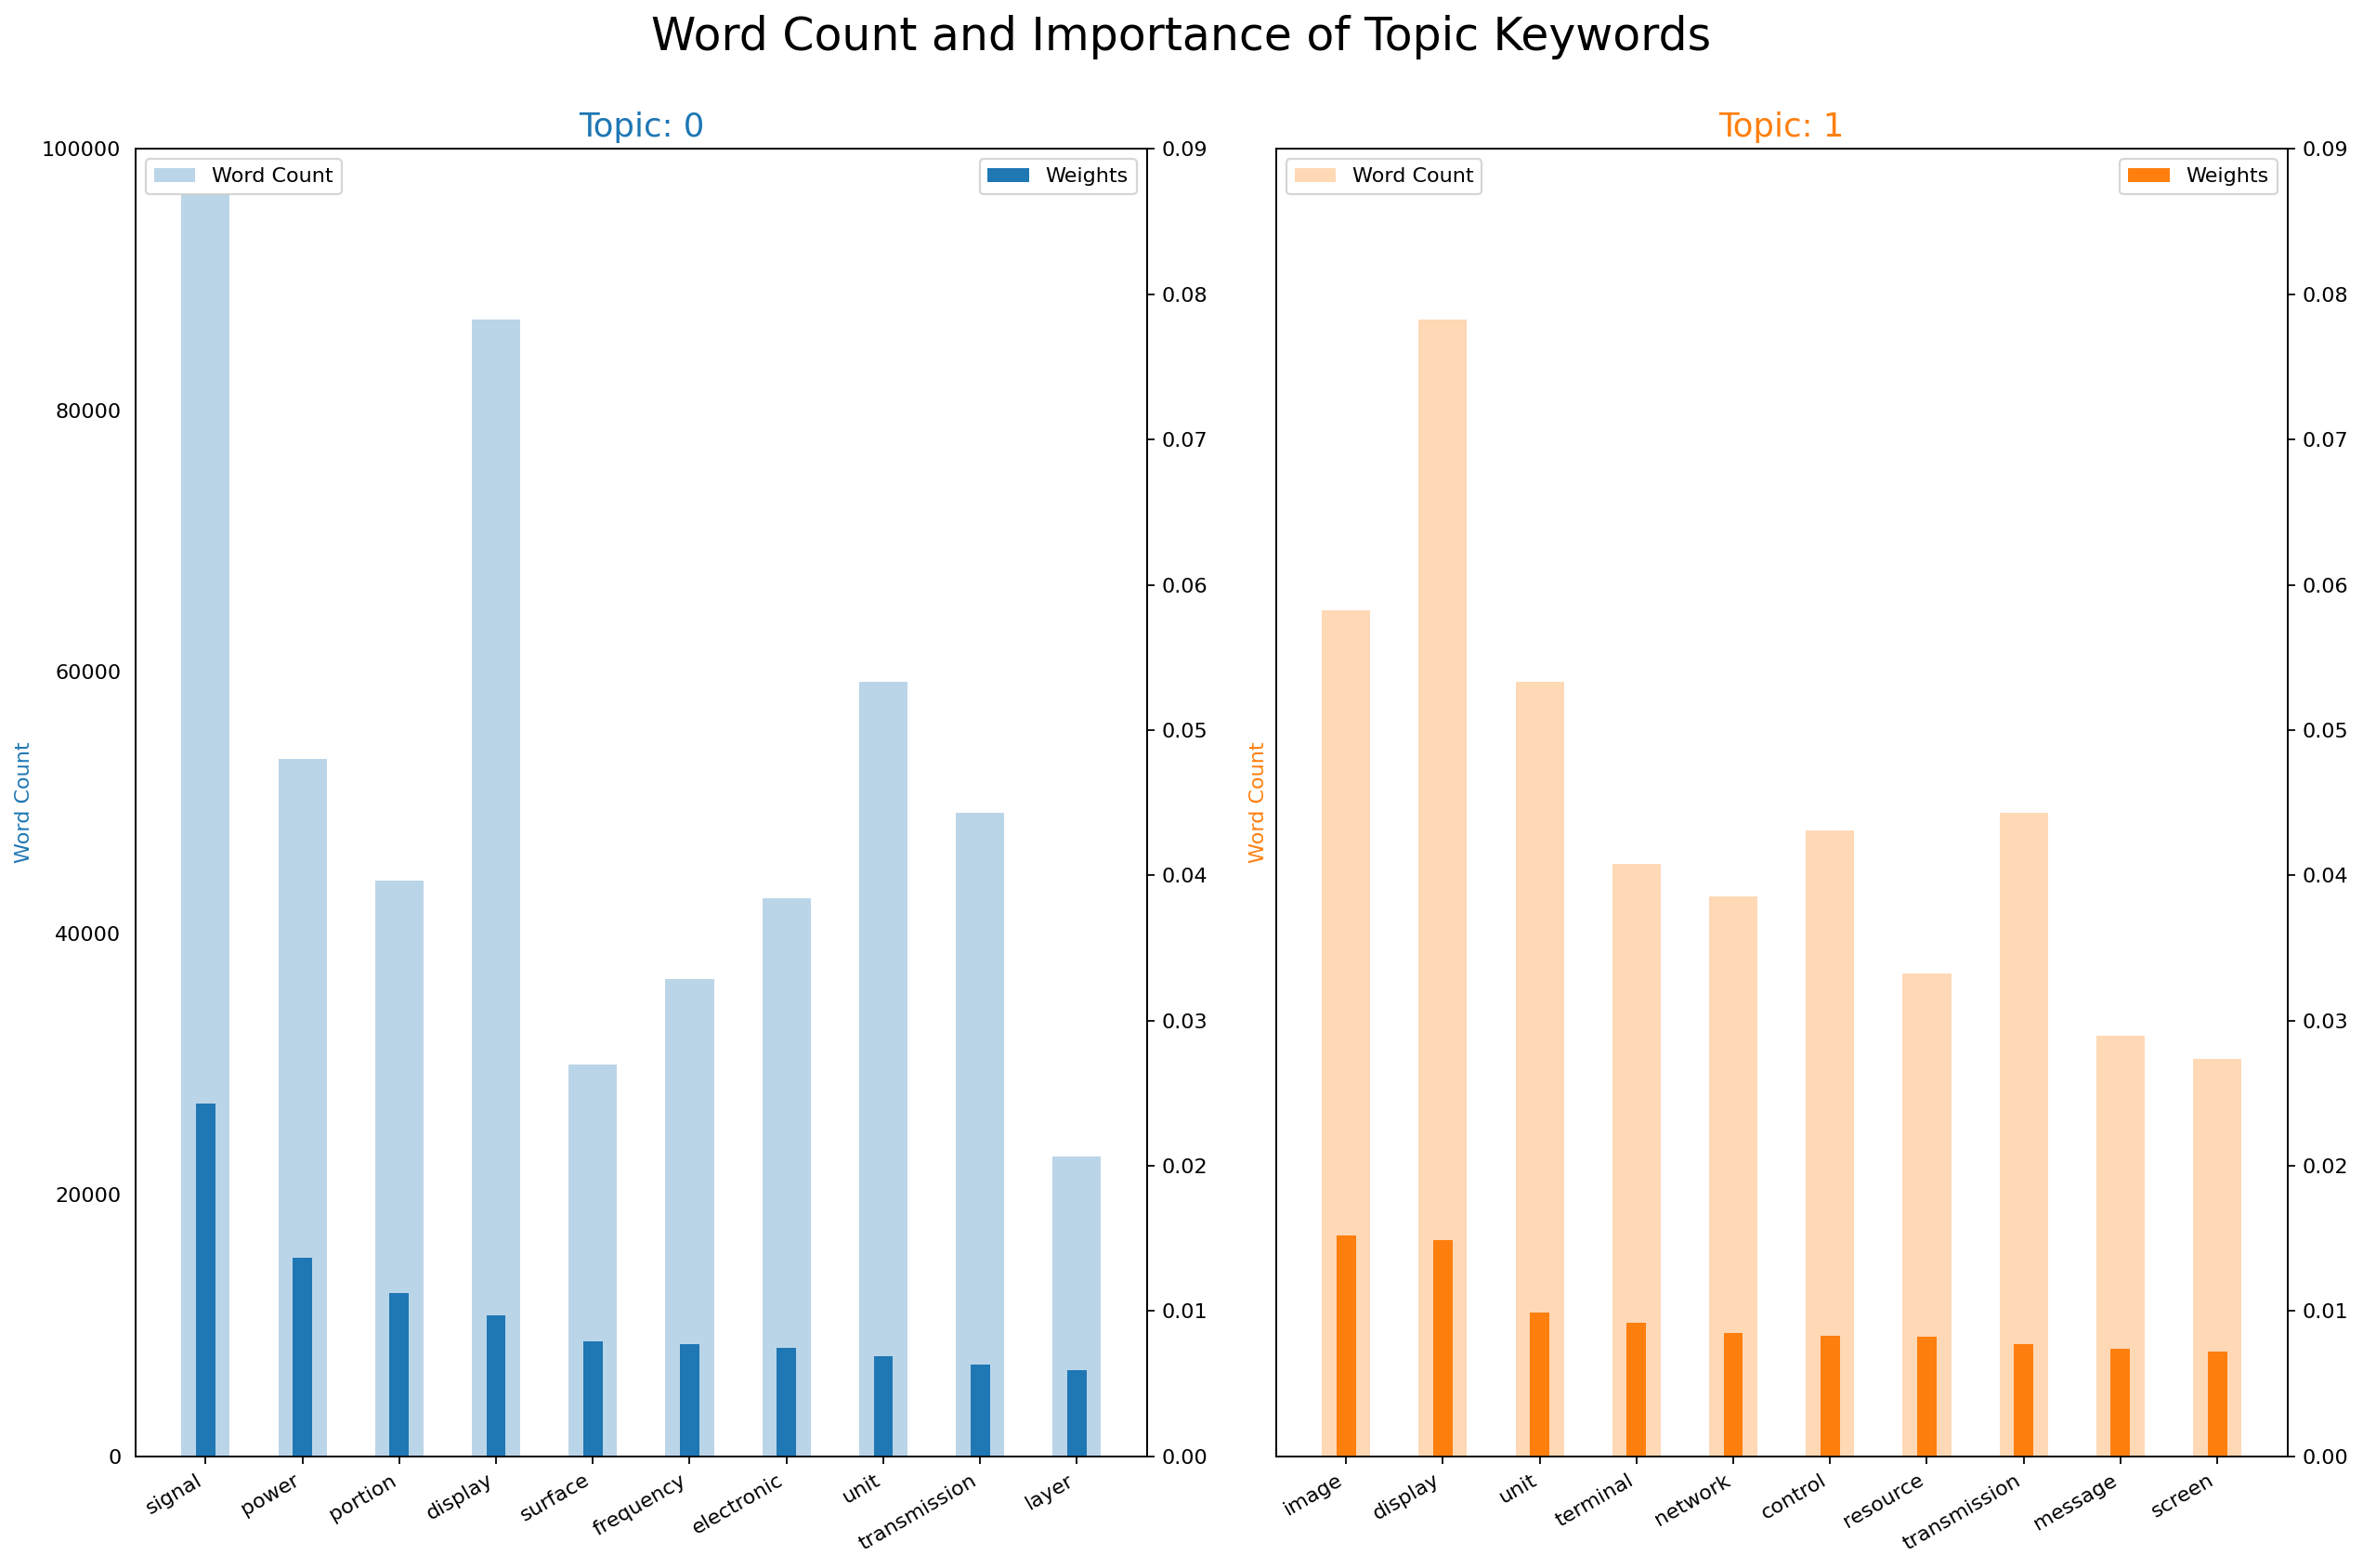

In [94]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3,
           label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id == i, :], color=cols[i], width=0.2,
                label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.09);
    ax.set_ylim(0, 100000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left');
    ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
print("show graph3")
plt.show()

График 4 - Раскраска темы предложения для документов

show graph4


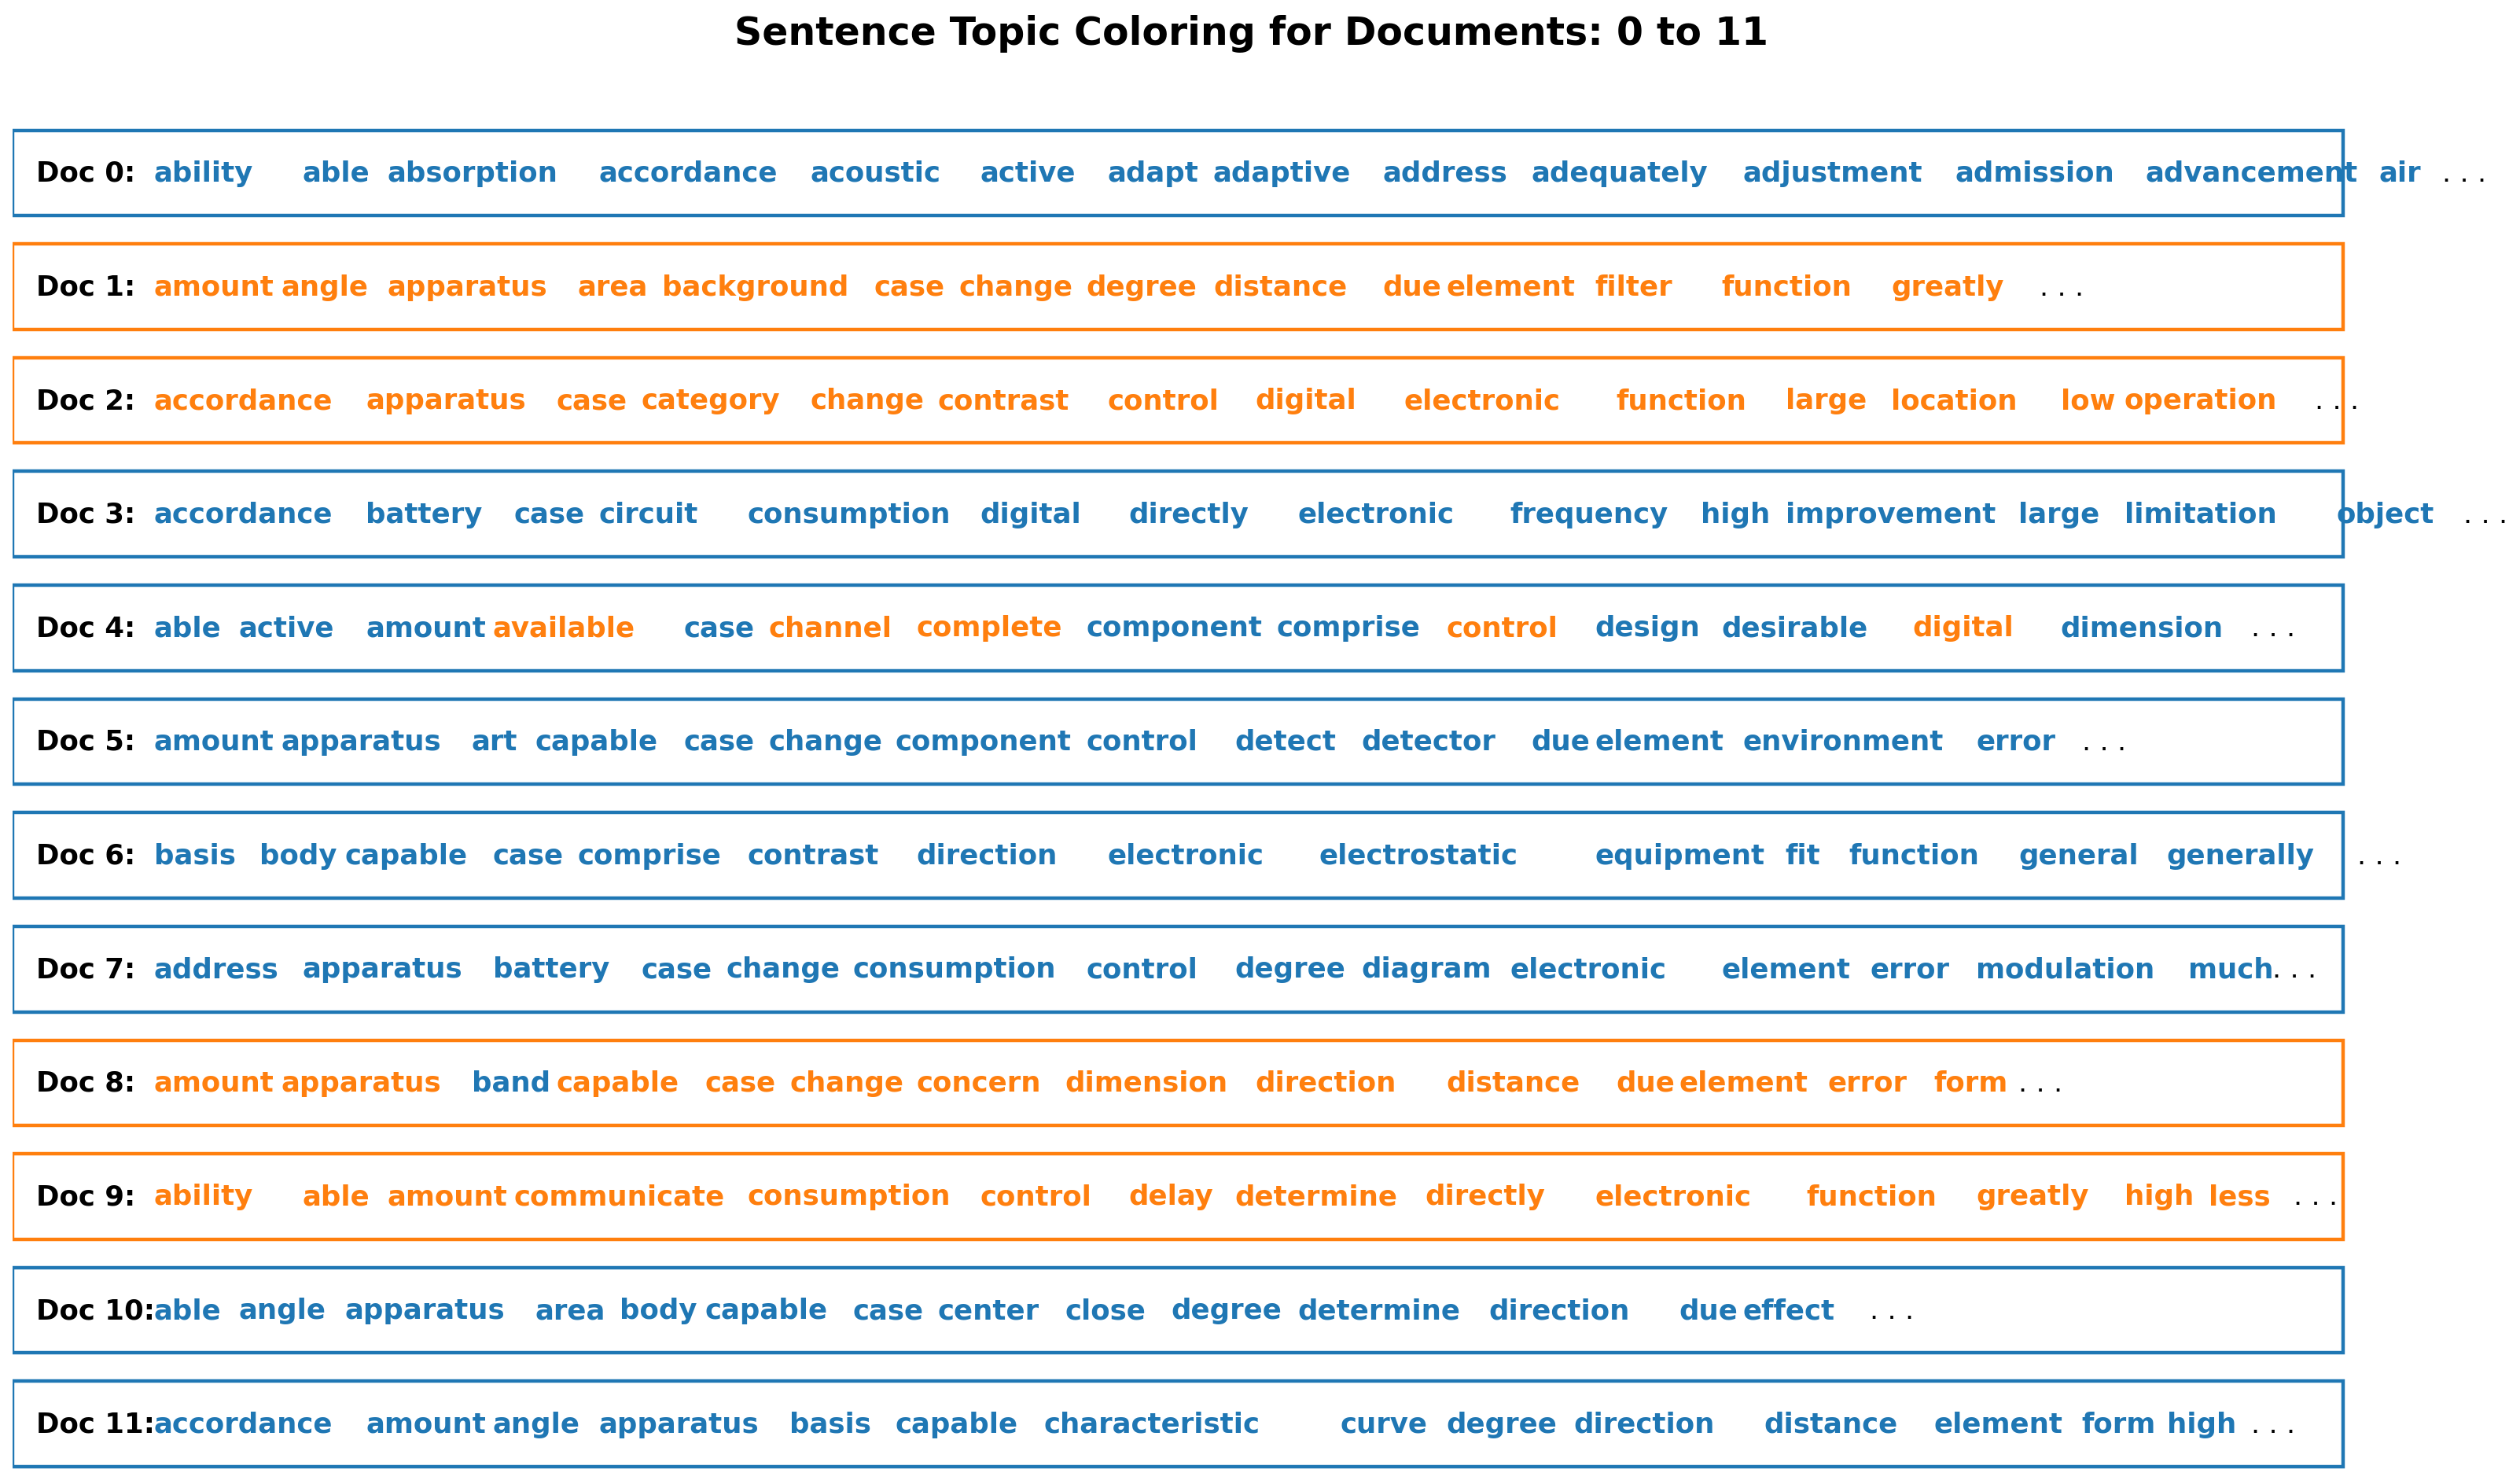

In [95]:
def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    fig, axes = plt.subplots(end - start, 1, figsize=(20, (end - start) * 0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i - 1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i - 1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)
            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))
            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end - 2), fontsize=22,
                 y=0.95, fontweight=700)
    plt.tight_layout()
    print("show graph4")
    plt.show()
sentences_chart()

Подготовка 3 топ слов по срезу топика

In [96]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return (dominant_topics, topic_percentages)
dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)
# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()
# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False)
                   for j, (topic, wt) in enumerate(topics) if j < 3]
df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0, inplace=True)

График 5 - Какие темы чаще всего обсуждаются в документах

show graph5


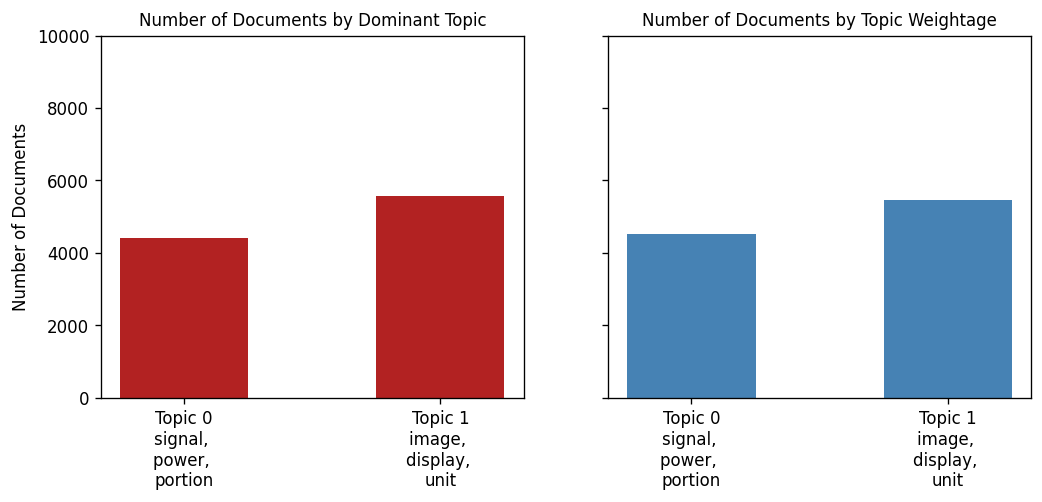

In [97]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(
    lambda x, pos: 'Topic ' + str(x) + '\n' + df_top3words.loc[df_top3words.topic_id == x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, rough_df.count())
# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
print("show graph5")
plt.show()

График 6

In [98]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 2
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.018s...
[t-SNE] Computed neighbors for 10000 samples in 0.159s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000001


c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.619850
[t-SNE] KL divergence after 1000 iterations: 0.421003


c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\bokeh\io\notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


Loading BokehJS ...

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\bokeh\io\notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\bokeh\io\notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\bokeh\io\notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


График 7

In [99]:
!pip install pyLDAvis;
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
print("show graph7")
vis

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


show graph7


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.070823  0.0       1        1  58.370127
0     -0.070823  0.0       2        1  41.629873, topic_info=             Term          Freq         Total Category  logprob  loglift
386        signal  92656.000000  92656.000000  Default  30.0000  30.0000
318         power  51075.000000  51075.000000  Default  29.0000  29.0000
536       portion  42220.000000  42220.000000  Default  28.0000  28.0000
518         image  67286.000000  67286.000000  Default  27.0000  27.0000
421       surface  28583.000000  28583.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
554          unit  19873.521429  59741.300195   Topic2  -4.9739  -0.2243
436  transmission  18223.384599  49405.297534   Topic2  -5.0606  -0.1210
209         input  16067.555799  41333.354313   Topic2  -5.1865  -0.0685
622         third  14525.591430  30590.644926   Topic2  -5.2874   0.1316
96        control  14934.507444  48408.919055   Topic2  -5.2596  -0.2997

[239 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
4          1  0.088737   acoustic
4          2  0.911178   acoustic
2376       1  0.019560   adhesive
2376       2  0.980331   adhesive
6630       1  0.997314        ais
...      ...       ...        ...
5651       2  0.022012  watermark
476        1  0.490270   wireless
476        2  0.509720   wireless
17140      1  0.989280       wtru
17140      2  0.010637       wtru

[398 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [100]:
def myfunc(ldamodel=None, corpus=corpus, texts=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(i), int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['i', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return (sent_topics_df)


df_topic_sents_keywords2 = myfunc(ldamodel=lda_model, corpus=corpus, texts=data_ready)

sparkDFGENSIM = spark.createDataFrame(df_topic_sents_keywords2)
sparkDFGENSIM.show(10)


window = pyspark.sql.Window.partitionBy("maingroup", "Dominant_Topic")
sparkdfgensimres = sparkDFGENSIM.withColumn("maingroup", when(sparkDFGENSIM.i < 5000, 1).otherwise(2)) \
    .select("Dominant_Topic", "maingroup").withColumn("countEachPatentToTopic",
                                                      count("Dominant_Topic").over(window)).distinct().orderBy("maingroup")

C:\Users\maksi\AppData\Local\Temp\ipykernel_10924\3075268018.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(
C:\Users\maksi\AppData\Local\Temp\ipykernel_10924\3075268018.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(


+---+--------------+------------------+--------------------+--------------------+
|  i|Dominant_Topic| Perc_Contribution|      Topic_Keywords|                   0|
+---+--------------+------------------+--------------------+--------------------+
|  0|             0|0.9711999893188477|signal, power, po...|[invention, audio...|
|  1|             1|0.9998000264167786|image, display, u...|[present, disclos...|
|  2|             1|0.9998000264167786|image, display, u...|[present, inventi...|
|  3|             0|0.9998000264167786|signal, power, po...|[present, inventi...|
|  4|             0|0.5494999885559082|signal, power, po...|[present, inventi...|
|  5|             0|0.7347000241279602|signal, power, po...|[present, disclos...|
|  6|             0|0.9265999794006348|signal, power, po...|[present, disclos...|
|  7|             0|0.8033999800682068|signal, power, po...|[present, inventi...|
|  8|             1|0.8167999982833862|image, display, u...|[present, inventi...|
|  9|           

In [101]:
sparkdfgensimres.show(10,False)

+--------------+---------+----------------------+
|Dominant_Topic|maingroup|countEachPatentToTopic|
+--------------+---------+----------------------+
|1             |1        |3311                  |
|0             |1        |1689                  |
|1             |2        |2275                  |
|0             |2        |2725                  |
+--------------+---------+----------------------+



# *PYSPARK LDA и графики*

In [73]:
num_topics=2
max_iterations=100
lda = LDA(k=num_topics, maxIter=max_iterations,optimizer='em')
ldaModel = lda.fit(count_vectorized_df)

In [74]:
# Print topics and top-weighted terms
topics = ldaModel.describeTopics(maxTermsPerTopic=10)
vocabArray = count_vectorized_model.vocabulary
numTopics=2

ListOfIndexToWords = udf(lambda wl: list([vocabArray[w] for w in wl]))
FormatNumbers = udf(lambda nl: ["{:1.4f}".format(x) for x in nl])

topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).show(truncate=False, n=numTopics)
topics.select(FormatNumbers(topics.termWeights).alias('weights')).show(truncate=False, n=numTopics)

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\pyspark\sql\context.py:118: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+----------------------------------------------------------------------------------------------------+
|words                                                                                               |
+----------------------------------------------------------------------------------------------------+
|[signal, communication, power, frequency, control, transmission, network, channel, resource, aspect]|
|[display, user, image, portion, unit, invention, sensor, interface, input, plurality]               |
+----------------------------------------------------------------------------------------------------+

+--------------------------------------------------------------------------------+
|weights                                                                         |
+--------------------------------------------------------------------------------+
|[0.0280, 0.0261, 0.0202, 0.0173, 0.0171, 0.0171, 0.0162, 0.0149, 0.0130, 0.0113]|
|[0.0276, 0.0223, 0.0213, 0.0149, 0.0117, 0.0116,

In [75]:
ldaModel.isDistributed()

True

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [77]:
from pyspark.sql.functions import when
dfspark = spark.createDataFrame(df)
dfspark2 = dfspark.withColumn("type", when(dfspark.Document_Id<5000, "1").when(dfspark.Document_Id<10000, "2"))
from pyspark.sql import Window
from pyspark.sql.functions import count
window = Window.partitionBy("type", "Dominant_Topic").orderBy("Dominant_Topic")
dfspark3 = dfspark2.select("type", "Dominant_Topic").withColumn("countEachPatentToTopic", count("Dominant_Topic").over(window)).distinct().orderBy("type")

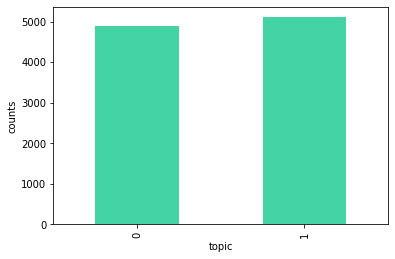

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\pyspark\sql\context.py:118: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


topic: 0
*************************
signal
communication
power
frequency
control
transmission
network
channel
resource
aspect
*************************
topic: 1
*************************
display
user
image
portion
unit
invention
sensor
interface
input
plurality
*************************


In [78]:
dfspark4 = dfspark3.select("Dominant_Topic", "countEachPatentToTopic").groupBy("Dominant_Topic").sum()
pdf = dfspark4.toPandas()
pdf.plot(color='#44D3A5', legend=False,
         kind='bar', use_index=True, y='sum(countEachPatentToTopic)', grid=False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

vocab = count_vectorized_model.vocabulary
topics = ldaModel.describeTopics()
topics_rdd = topics.rdd
topics_words = topics_rdd \
    .map(lambda row: row['termIndices']) \
    .map(lambda idx_list: [vocab[idx] for idx in idx_list]) \
    .collect()
for idx, topic in enumerate(topics_words):
    print("topic: {}".format(idx))
    print("*" * 25)
    for word in topic:
        print(word)
    print("*" * 25)


In [79]:
dfspark3.show(10,False)

+----+--------------+----------------------+
|type|Dominant_Topic|countEachPatentToTopic|
+----+--------------+----------------------+
|1   |1             |2675                  |
|1   |0             |2325                  |
|2   |1             |2433                  |
|2   |0             |2566                  |
+----+--------------+----------------------+



In [80]:
def format_data_to_pyldavis(df_filtered, count_vectorizer, transformed, lda_model):
    xxx = df_filtered.select((explode(df_filtered.lemmatized_good_words)).alias("words")).groupby("words").count()
    word_counts = {r['words']:r['count'] for r in xxx.collect()}
    word_counts = [word_counts[w] for w in count_vectorizer.vocabulary]


    data = {'topic_term_dists': np.array(lda_model.topicsMatrix().toArray()).T, 
            'doc_topic_dists': np.array([x.toArray() for x in transformed.select(["topicDistribution"]).toPandas()['topicDistribution']]),
            'doc_lengths': [r[0] for r in df_filtered.select(size(df_filtered.lemmatized_good_words)).collect()],
            'vocab': count_vectorizer.vocabulary,
            'term_frequency': word_counts}

    return data

def filter_bad_docs(data):
    bad = 0
    doc_topic_dists_filtrado = []
    doc_lengths_filtrado = []

    for x,y in zip(data['doc_topic_dists'], data['doc_lengths']):
        if np.sum(x)==0:
            bad+=1
        elif np.sum(x) != 1:
            bad+=1
        elif np.isnan(x).any():
            bad+=1
        else:
            doc_topic_dists_filtrado.append(x)
            doc_lengths_filtrado.append(y)

    data['doc_topic_dists'] = doc_topic_dists_filtrado
    data['doc_lengths'] = doc_lengths_filtrado


In [81]:
!pip install pyLDAvis

In [82]:
import pyLDAvis
from pyspark.ml.feature import StopWordsRemover,Tokenizer, RegexTokenizer, CountVectorizer, IDF
from pyspark.sql.functions import udf, col, size, explode, regexp_replace, trim, lower, lit
from pyspark.sql.types import ArrayType, StringType, DoubleType, IntegerType, LongType
from pyspark.ml.clustering import LDA
pyLDAvis.enable_notebook()
data = format_data_to_pyldavis(count_vectorized_df, count_vectorized_model, ldaModel.transform(count_vectorized_df), ldaModel)
filter_bad_docs(data) # this is, because for some reason some docs apears with 0 value in all the vectors, or the norm is not 1, so I filter those docs.
py_lda_prepared_data = pyLDAvis.prepare(**data)
pyLDAvis.display(py_lda_prepared_data)

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


# *SKLEARN LDA и графики*

In [83]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

docs_raw = pd.read_parquet('G:/Мой диск/datasetGH.parquet')['text'].tolist()
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 0.02)
dtm_tf = tf_vectorizer.fit_transform(docs_raw)
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


In [84]:
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=2, random_state=0,learning_method='online')
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(learning_method='online', n_components=2,
                          random_state=0)

      Topic0  Topic1  dominant_topic doc_id  doc_type
0       0.69    0.31               0      0         0
1       0.80    0.20               0      1         0
2       0.86    0.14               0      2         0
3       0.82    0.18               0      3         0
4       0.90    0.10               0      4         0
...      ...     ...             ...    ...       ...
9995    0.90    0.10               0   9995         1
9996    0.86    0.14               0   9996         1
9997    0.71    0.29               0   9997         1
9998    0.46    0.54               1   9998         1
9999    0.83    0.17               0   9999         1

[10000 rows x 5 columns]
   dominant_topic  doc_type  counts
0               0         0    2359
1               0         1    4294
2               1         0    2641
3               1         1     706


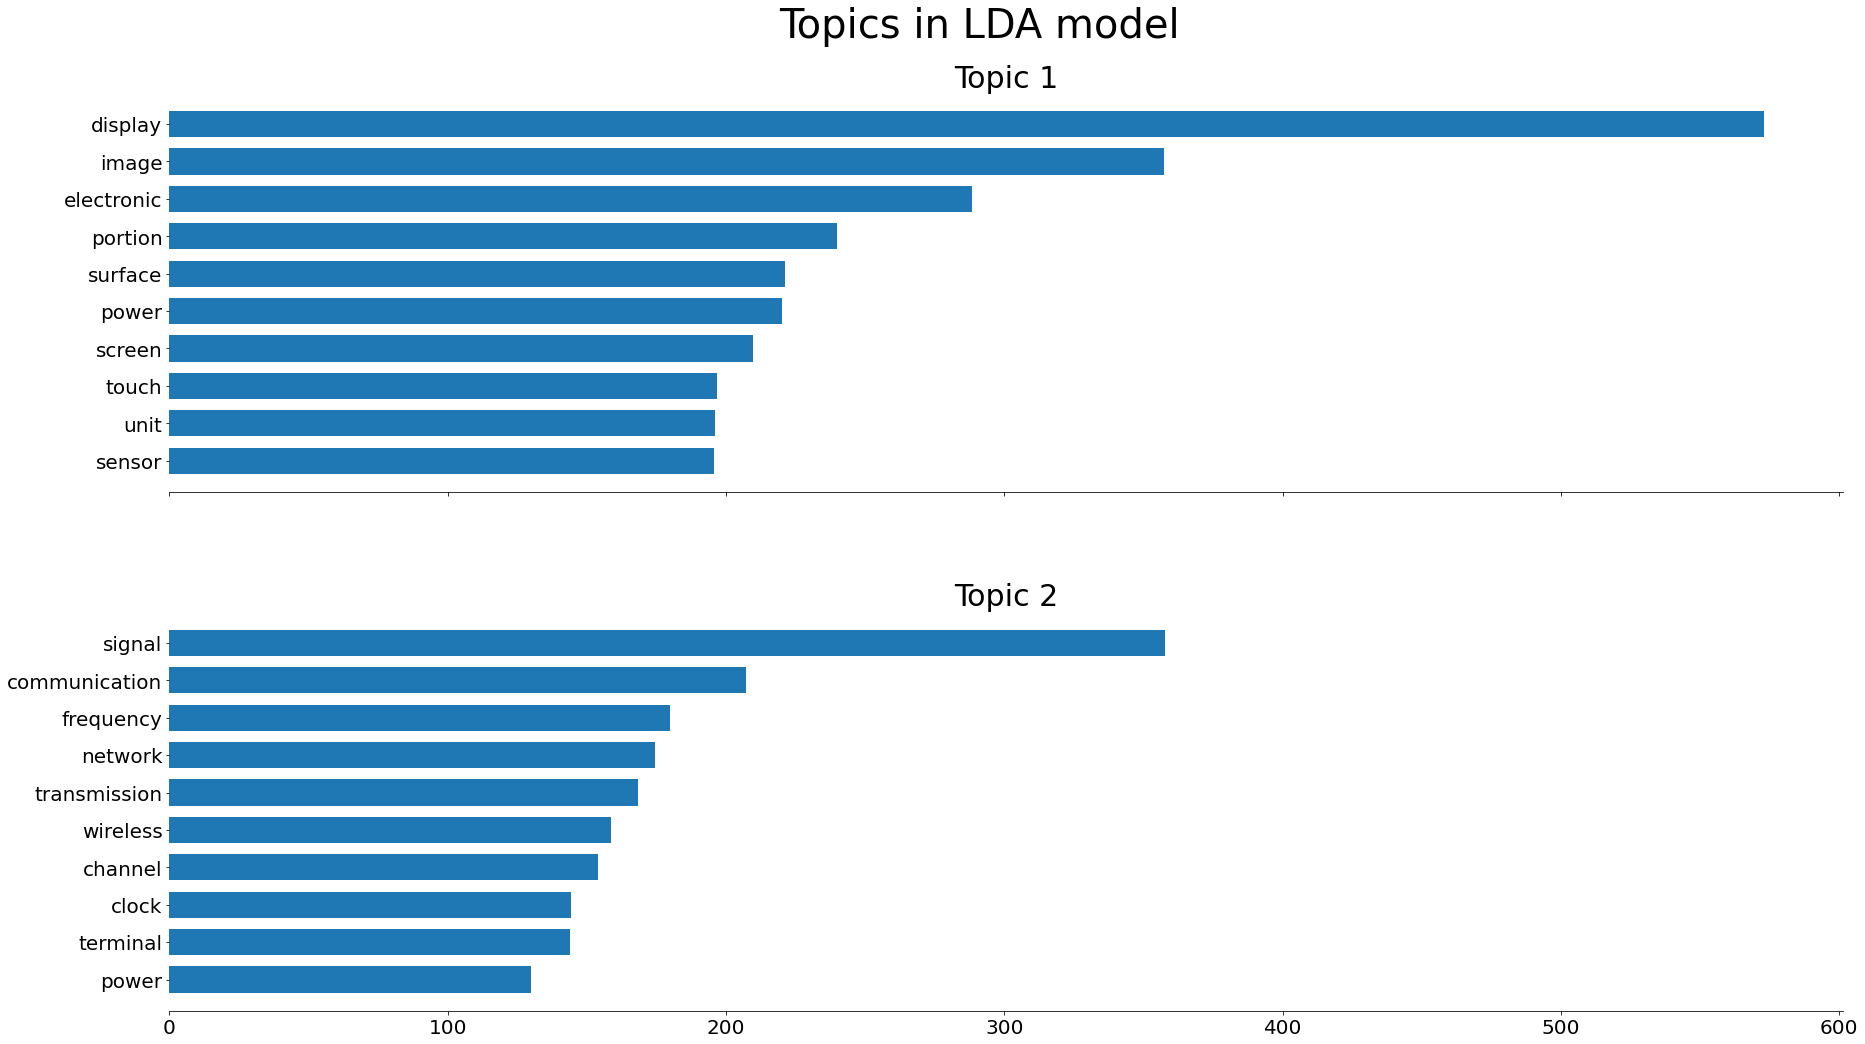

In [85]:
from math import floor

lda_output = lda_tfidf.transform(dtm_tfidf)

# Create Document — Topic Matrix
topicnames = ["Topic" + str(i) for i in range(lda_tfidf.n_components)]
# index names
docnames = [str(i) for i in range(len(docs_raw))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["dominant_topic"] = dominant_topic
df_document_topic["doc_id"] = df_document_topic.index
df_document_topic["doc_type"] = [floor(i / (len(docs_raw) / lda_tfidf.n_components)) for i in range(len(docs_raw))]

print(df_document_topic)

testdf = df_document_topic[['dominant_topic','doc_type']]\
    .groupby(['dominant_topic','doc_type'])\
    .size().reset_index(name="counts")

print(testdf)

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 1, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1: -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda_tfidf, tf_feature_names, 10, "Topics in LDA model")

In [86]:
!pip install pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.138887  0.0       1        1  59.732965
1     -0.138887  0.0       2        1  40.267035, topic_info=              Term        Freq       Total Category  logprob  loglift
2047        signal  417.000000  417.000000  Default  30.0000  30.0000
667        display  514.000000  514.000000  Default  29.0000  29.0000
958      frequency  197.000000  197.000000  Default  28.0000  28.0000
2286  transmission  184.000000  184.000000  Default  27.0000  27.0000
1447       network  193.000000  193.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
1715     processor  108.420709  176.805657   Topic2  -5.5061   0.4206
206           base   95.879675  133.797716   Topic2  -5.6290   0.5764
120      apparatus  112.364081  217.891251   Topic2  -5.4704   0.2474
332        circuit  103.791135  216.892282   Topic2  -5.5497   0.1726
1372        memory   96.426772  154.988720   Topic2  -5.6233   0.4351

[141 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
7         1  0.047469     access
7         2  0.949380     access
115       1  0.076671    antenna
115       2  0.920053    antenna
120       1  0.486481  apparatus
...     ...       ...        ...
2378      2  0.011178    virtual
2401      1  0.996568   wearable
2401      2  0.007786   wearable
2415      1  0.089064   wireless
2415      2  0.911597   wireless

[203 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

# K-Means (TEST)


In [87]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=2)
model_kmeans = kmeans.fit(count_vectorized_df)
resultdf_kmeans = model_kmeans.transform(count_vectorized_df)


In [88]:
resultdf_kmeans.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  610|
|         0| 9390|
+----------+-----+

